# Benchmarks for Trading environment

The notebook provides testing and comparison between deterministic policies and pretrained RL agents strategies among the `TradingEnv` environment.
It is also possible to retrain from scratch the agents, by changing the corresponding flags.

In [1]:
import gym4real.envs.trading
from stable_baselines3.common.monitor import Monitor
from gym4real.envs.trading.utils import parameter_generator
import gymnasium as gym
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from sbx import PPO
from stable_baselines3 import DQN
from gym4real.algorithms.trading.utils import evaluate_multiple_agents_with_baselines
import os

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/giovannidispoto/Desktop/PhD/gym4real_rep/gym4ReaL


In [3]:
base_directory = "./examples/trading/trained_models"

In [4]:
args = {
        'exp_name': 'trading/ppo',
        'n_episodes': 30,
        'n_envs': 6,
        'policy_kwargs': dict(net_arch=[512, 512]),
        'verbose': False,
        'gamma': 0.90,
        'learning_rate': 0.0001,
        'log_rate': 10,
        'batch_size': 236,
        'n_steps':  118*6,
        'ent_coeff': 0.,
        'save_model_as': 'ppo_sr_10_eps',
        'seeds': [32517, 84029, 10473, 67288, 91352, 47605]
    }

In [5]:
params_train = parameter_generator(world_options='gym4real/envs/trading/world_train.yaml')
params_validation = parameter_generator(world_options='gym4real/envs/trading/world_validation.yaml')
params_test = parameter_generator(world_options='gym4real/envs/trading/world_test.yaml')


## Training or Loading PPO agent

Set train_ppo = True if you want to train PPO agent using the specified configuration

In [ ]:


train_ppo = False

if train_ppo is True: #Train PPO
    for seed in args['seeds']:
        print("######## PPO is running... ########")
        
        train_env = make_vec_env("gym4real/TradingEnv-v0", n_envs=args['n_envs'], env_kwargs={'settings':params_train, 'seed': seed})
        eval_env = gym.make("gym4real/TradingEnv-v0", **{'settings':params_validation, 'scaler':train_env.env_method('get_scaler')[0]})
        eval_env = Monitor(eval_env)
        
        base_logdir = os.path.join(base_directory, args['exp_name'])
        logdir = os.path.join(base_directory, args['exp_name']+f"_seed_{seed}")
        tensordir = os.path.join(base_directory, "tensorboard", args['exp_name'])
        os.makedirs(logdir, exist_ok=True)
        os.makedirs(tensordir, exist_ok=True)
        os.makedirs(base_logdir, exist_ok=True)
        
        eval_callback = EvalCallback(eval_env,
                                     best_model_save_path=os.path.join(logdir, "models/eval"),
                                     log_path=None,
                                     eval_freq= (1 * train_env.env_method("get_trading_day_num")[0] * 118) / 2,
                                     n_eval_episodes=eval_env.unwrapped.get_trading_day_num(),
                                     deterministic=True,
                                     render=False)


        callbacks = [eval_callback]

        model = PPO("MlpPolicy",
                    env=train_env,
                    verbose=args['verbose'],
                    gamma=args['gamma'],
                    policy_kwargs=args['policy_kwargs'],
                    n_steps=args['n_steps'],
                    tensorboard_log=tensordir,
                    learning_rate=args['learning_rate'],
                    batch_size = args['batch_size'],
                    seed=seed
                    )

        model.learn(total_timesteps= args['n_episodes'] * train_env.env_method("get_trading_day_num")[0] * 598,
                    progress_bar=True,
                    log_interval=args['log_rate'],
                    tb_log_name="ppo_{}".format(args['exp_name']+f"_seed_{seed}"),
                    callback=callbacks,
                    reset_num_timesteps=True,)

        model.save(os.path.join(logdir, "models", args['save_model_as'] ))
        print("######## TRAINING is Done ########") 
else:
    train_env = make_vec_env("gym4real/TradingEnv-v0",  n_envs=args['n_envs'], env_kwargs={'settings':params_train} )
    eval_env = gym.make("gym4real/TradingEnv-v0", **{'settings':params_validation, 'scaler':train_env.env_method('get_scaler')[0]})
#Load Best PPO models
models_ppo = []
for seed in args['seeds']:
    logdir = os.path.join(base_directory, args['exp_name']+f"_seed_{seed}" )
    model = PPO.load(os.path.join(logdir,  "models/eval", "best_model"))
    models_ppo.append(model)
    

/Users/giovannidispoto/miniconda3/envs/gym4real_new/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
/Users/giovannidispoto/miniconda3/envs/gym4real_new/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
/Users/giovannidispoto/miniconda3/envs/gym4real_new/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that is not in the possible render_modes ([]).
  logger.warn(
/Users/giovannidispoto/miniconda3/envs/gym4real_new/lib/python3.12/site-packages/gymnasium/envs/registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_array' that i

In [ ]:
args = {
        'exp_name': 'trading/dqn',
        'n_episodes': 30,
        'n_envs': 6,
        'policy_kwargs': dict(
            net_arch=[512, 512]
        ),
        'verbose': False,
        'gamma': 0.90,
        'learning_rate': 0.0001,
        'log_rate': 10,
        'batch_size': 64,
        'buffer_size': 1000000,
        'learning_starts': 100,
        'exploration_fraction': 0.2,
        'exploration_final_eps': 0.05,
        'tau': 1.0,
        'train_freq': 4,
        'save_model_as': 'dqn_trading_10eps',
        'seeds': [32517, 84029, 10473, 67288, 91352, 47605]
    }

## Train or Load DQN
Set train_dqn = True if you want to train DQN agent using the specified configuration

In [ ]:
train_dqn = False

if train_dqn is True:
    for seed in args['seeds']:
        print("######## DQN is running... ########")
        logdir = "./logs/" + args['exp_name']
        os.makedirs(logdir, exist_ok=True)
        train_env = make_vec_env("gym4real/TradingEnv-v0", n_envs=args['n_envs'],env_kwargs={'settings': params_train, 'seed':seed})
        eval_env = gym.make("gym4real/TradingEnv-v0", **{'settings': params_validation, 'scaler': train_env.env_method('get_scaler')[0], 'seed': seed})
        eval_env = Monitor(eval_env)
        
        base_logdir = os.path.join(base_directory, args['exp_name'])
        logdir = os.path.join(base_directory, args['exp_name']+f"_seed_{seed}")
        tensordir = os.path.join(base_directory, "tensorboard", args['exp_name'])
        os.makedirs(logdir, exist_ok=True)
        os.makedirs(tensordir, exist_ok=True)
        os.makedirs(base_logdir, exist_ok=True)

        eval_callback = EvalCallback(eval_env,
                                     best_model_save_path=os.path.join(logdir, "models/eval"),
                                     log_path=None,
                                     eval_freq=(1 * train_env.env_method("get_trading_day_num")[0] * 118) / 2,
                                     n_eval_episodes=eval_env.unwrapped.get_trading_day_num(),
                                     deterministic=True,
                                     render=False)

        callbacks = [eval_callback]
        model = DQN("MlpPolicy",
                    env=train_env,
                    verbose=args['verbose'],
                    gamma=args['gamma'],
                    policy_kwargs=args['policy_kwargs'],
                    tensorboard_log=tensordir,
                    stats_window_size=100,
                    learning_rate=args['learning_rate'],
                    batch_size=args['batch_size'],
                    buffer_size=args['buffer_size'],
                    learning_starts=args['learning_starts'],
                    exploration_fraction=args['exploration_fraction'],
                    exploration_final_eps=args['exploration_final_eps'],
                    tau=args['tau'],
                    train_freq=args['train_freq'],
                    seed=seed
                    )

        model.learn(total_timesteps= args['n_episodes'] * train_env.env_method("get_trading_day_num")[0] * 598,
                    progress_bar=True,
                    log_interval=args['log_rate'],
                    tb_log_name="dqn_{}".format(args['exp_name']),
                    callback=callbacks,
                    reset_num_timesteps=True, )
        
        model.save(os.path.join(logdir, "models", args['save_model_as'] ))
        print("######## TRAINING is Done ########")
else:
    train_env = make_vec_env("gym4real/TradingEnv-v0",  n_envs=args['n_envs'], env_kwargs={'settings':params_train} )
    eval_env = gym.make("gym4real/TradingEnv-v0", **{'settings':params_validation, 'scaler':train_env.env_method('get_scaler')[0]})
#Load Best PPO models
models_dqn = []
for seed in args['seeds']:
    logdir = os.path.join(base_directory, args['exp_name']+f"_seed_{seed}" )
    model = DQN.load(os.path.join(logdir,  "models/eval", "best_model"))
    models_dqn.append(model)
    

### Evaluation

Evaluation of the trained agents on Training Years (2019-2020), Validation Year (2021) and Test Year (2022)

In [10]:
models = {
    "PPO": models_ppo,
    "DQN": models_dqn
}

/Users/giovannidispoto/Desktop/PhD/gym4ReaL_github/gym4ReaL/gym4real/algorithms/trading/utils.py:285: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "Strategy", y = "Daily P&L", data = plot_data, palette=palette)


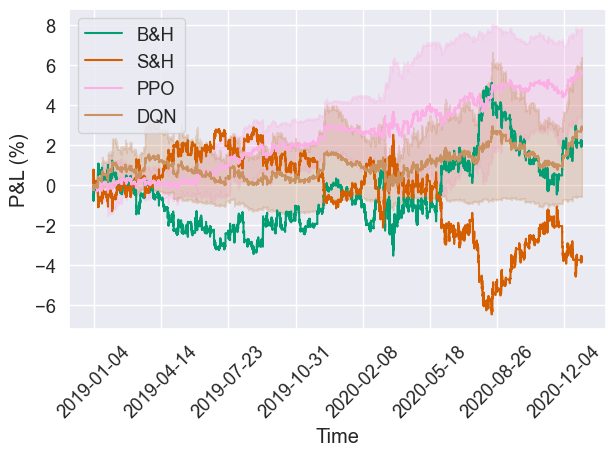

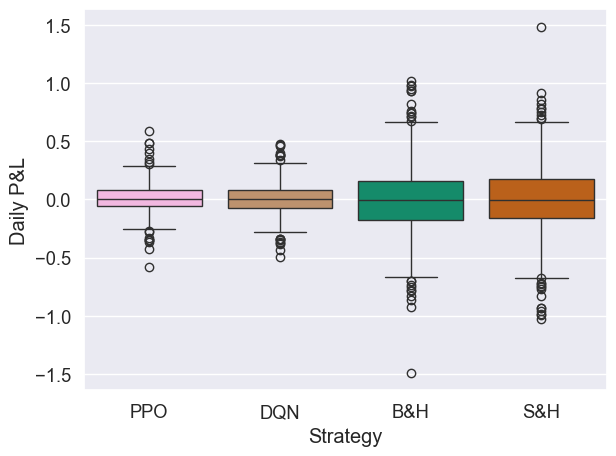

In [11]:
params_train['sequential'] = True
evaluate_multiple_agents_with_baselines(models, params_train, None, 'Training', "./gym4real/algorithms/trading/plots/" )

/Users/giovannidispoto/Desktop/PhD/gym4ReaL_github/gym4ReaL/gym4real/algorithms/trading/utils.py:285: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "Strategy", y = "Daily P&L", data = plot_data, palette=palette)


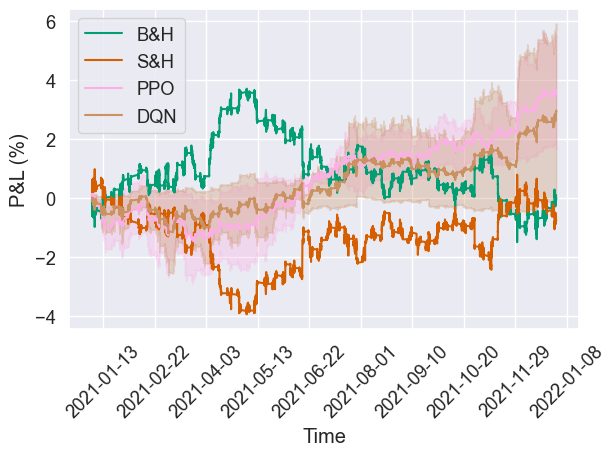

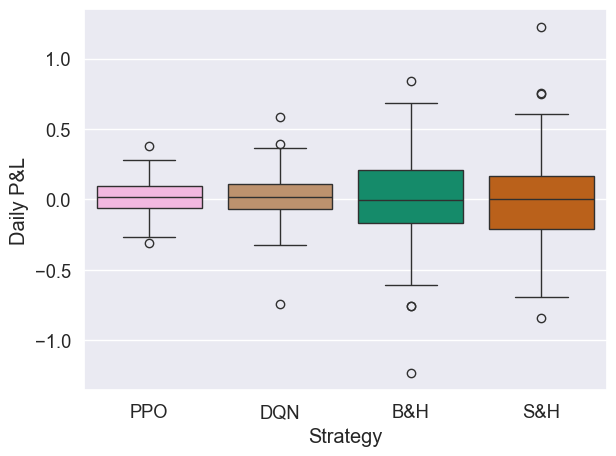

In [12]:
evaluate_multiple_agents_with_baselines(models, params_validation, train_env.env_method("get_scaler")[0], 'Validation', "./gym4ReaL/algorithms/trading/plots/")

/Users/giovannidispoto/Desktop/PhD/gym4ReaL_github/gym4ReaL/gym4real/algorithms/trading/utils.py:285: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "Strategy", y = "Daily P&L", data = plot_data, palette=palette)


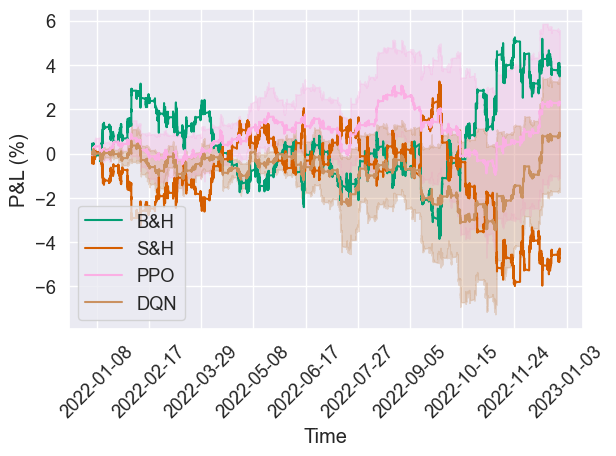

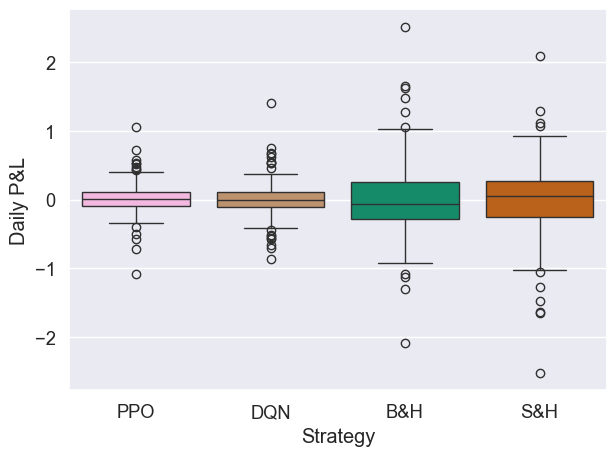

In [13]:
evaluate_multiple_agents_with_baselines(models, params_test, train_env.env_method("get_scaler")[0], 'Test', "./gym4real/algorithms/trading/plots/")